<h1 align="center"> Statistiques Multivariées (DS): Projet de reconnaissance vocale </h1>

Consignes:
----------
- Deadline: *Dimanche 10 Novembre 23h59* | tout retard d'1h = -1
- Il faut nommer le fichier avec le numéro du groupe seulement: ex "groupe_4.ipynb"
- PAS DE PDF NI DE FICHIER WORD. UN NOTEBOOK UNIQUEMENT.
- Les noms des membres du groupe sont à mentionner en modifiant la ligne suivante:

Membre 1: 

Membre 2:

Membre 3:

Membre 4:

- Ce notebook contient 10 questions + une question bonus.
- Il faut executer tout le notebook (Run all cells) avant de l'envoyer: vérifier que les cellules sont exécutées dans le bon ordre et qu'il n'y a pas d'erreur, je ne vais pas débugger votre code. 
- Le code doit être propre et lisible et surtout comprendre ce qu'il fait par tous les membres du groupe.
- LIVRAISON UNIQUEMENT SUR DROPBOX (TOUT FICHIER ENVOYE PAR MAIL NE SERA PAS OUVERT):

   https://www.dropbox.com/request/fPpGIeywHPow125tCWzo

   Vous pouvez effectuer plusieurs uploads, seule la date la plus récente sera corrigée.


# Installation
Commencer d'abord par installer les packages nécessaires en lançant dans un terminal:
- `pip install -r requirements.txt`

Ou directement dans une cellule notebook:

- `%pip install -r requirements.txt`

# Les données:
Le dossier "data/raw" contient des milliers d'enregistrements audio de 10 personnes (5 hommes et 5 femmes) américaines. Le but de ce projet et d'analyser ces données et de construire un modèle simple de reconnaissance vocale. C'est à dire, reconnaitre la personne qui parle parmi les 10. Voici à quoi ressemble un enregistrement:

In [1]:
from IPython.display import Audio
import librosa

y1, sr1 = librosa.load("data/raw/f0001_us_f0001_00001.wav", sr=None)
Audio(data=y1, rate=sr1)



In [2]:
print(y1)
print(f"La taille du fichier audio est {y1.shape}")

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.4414062e-04
 -1.8310547e-04 -6.1035156e-05]
La taille du fichier audio est (74880,)


Nous allons commencer par extraire des informations sur le timbre (en utilisant le domaine temps-fréquence) de l'enregistrement avec les Mel Frequency Cepstral Coefficient (MFCC):

In [3]:
mfcc = librosa.feature.mfcc(y=y1, sr=sr1, n_mfcc=10)
print(mfcc)
print(f"La taille des coefficients est {mfcc.shape}")

[[-676.00336   -628.5445    -630.0368    ... -587.2241    -618.89246
  -651.83386  ]
 [  37.224       47.90239     46.27678   ...   56.477764    54.10054
    50.65921  ]
 [  23.1025      21.160934    22.697372  ...   15.998567    18.13808
    22.942192 ]
 ...
 [   6.695296     6.1194553    2.1517377 ...   12.616104     8.677283
     9.154582 ]
 [   6.19289      1.8975844    1.6943828 ...   17.54723     14.119264
    11.321548 ]
 [  -1.1161003   -5.9224443   -5.273529  ...    8.176836     5.331137
     3.8546567]]
La taille des coefficients est (10, 147)


On peut visualiser ces 10 coefficients dans le temps:

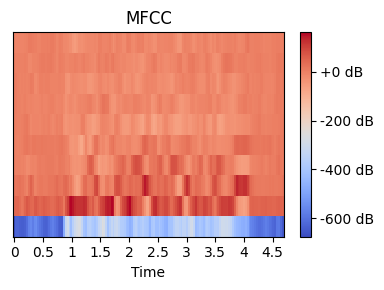

In [4]:
from matplotlib import pyplot as plt

# Plotting the MFCCs
plt.figure(figsize=(4, 3))
librosa.display.specshow(mfcc, x_axis='time', sr=sr1)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.tight_layout()
plt.show()


Nous allons résumer ces coefficients en calculant leur moyenne temporelle. Ainsi, chaque fichier audio doit être transformé par un vecteur de taille 13:

In [5]:
mfcc_moyenne = mfcc.mean(axis=1)
mfcc_moyenne

array([-447.81406  ,   63.020832 ,   30.160313 ,    7.9655695,
          2.1016788,  -22.293121 ,   -7.862449 ,  -12.084611 ,
         -1.8244214,   -6.8137836], dtype=float32)

On construit donc le dataset avec la fonction suivante:


In [6]:
import pandas as pd

folder_path = "data/raw/"
n_recordings = 50
n_coefs = 10
data = []
for gender in ["m", "f"]:
    for speaker in range(1, 6):
        for recording_id in range(1, n_recordings + 1):
            file_name = "%s%04d_us_%s%04d_%05d.wav" %(gender, speaker, gender, speaker, recording_id)
            y, sr = librosa.load(folder_path + file_name)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_coefs).mean(axis=1)

            speaker_id = speaker - 1
            if gender == "f":
                speaker_id += 5
            row_data = {
                'FileName': file_name,
                'Gender': gender,
                'SpeakerID': speaker_id,
                'RecordingID': recording_id,
            }
            for i in range(n_coefs):
                row_data[f'MFCC_{i+1}'] = mfcc[i]
            
            data.append(row_data)

df = pd.DataFrame(data)

In [7]:
df.head()

FileName Gender  SpeakerID  RecordingID      MFCC_1  \
0  m0001_us_m0001_00001.wav      m          0            1 -432.045410   
1  m0001_us_m0001_00002.wav      m          0            2 -448.635986   
2  m0001_us_m0001_00003.wav      m          0            3 -433.696320   
3  m0001_us_m0001_00004.wav      m          0            4 -427.338989   
4  m0001_us_m0001_00005.wav      m          0            5 -412.676575   

       MFCC_2    MFCC_3     MFCC_4     MFCC_5     MFCC_6    MFCC_7    MFCC_8  \
0  119.769264 -3.836545  25.336601 -13.802796  16.731417 -2.733350  2.620323   
1  114.177414 -5.153249  16.764275 -20.626694  20.666161 -5.741008  9.305303   
2   94.268806 -3.704444  24.321095 -15.773801  16.456257  0.998079  5.189480   
3  113.769791 -8.063369  25.546103 -15.735123  12.846508 -0.483539  5.328898   
4  102.270454 -9.136461  29.005512 -12.034924  23.754646 -7.142555 -0.976251   

      MFCC_9   MFCC_10  
0  -9.290769  3.606286  
1  -5.688132  0.833428  
2  -8.003875  4.879942  
3 -16.783321  1.889776  
4 -14.627462  3.513205

# Partie I:
#### 1. Effectuez une PCA sur les coefficients MFCC en visualisant le genre avec deux couleurs différentes. 


#### 2. On suspecte que les enregistrements du `speaker` 4 forment deux sous-groupes très distincts: les `recordingID` paires et impaires. Effectuez un test pour vérifier cette hypothèse.

#### 3. Proposez une analyse statistique (et effectuez la) pour évaluer si différence entre les hommes et les femmes est significative. 


#### 4. Compte tenu de ce résultat, comment peut-on implémenter un modèle de prédiction (avec numpy seulement) du sexe basé sur le calcul d'une distance ? 


# Partie II: Reconnaissance vocale
On souhaite désormais apprendre à prédire `Y = speaker_id` avec les données `X = MFCCS` en utilisant des modèles de classification (avec scikit-learn). On découpe le dataset en deux parties:
- `(X_train, y_train)`: utilisé pour "entrainer" le modèle, c-à-d on suppose que les `y_train` sont connues.
- `(X_train, y_test)`: utilisé pour "tester" le modèle, c-à-d on suppose que les `y_train` ne sont pas connues à l'avance et sont utilisés uniquement après avoir entrainé le modèle pour l'évaluer.


In [8]:
from sklearn.model_selection import train_test_split

X = df[[f"MFCC_{i}" for i in range(1, 11)]].values
y = df.SpeakerID.values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True, test_size=0.25)

#### 5. Évaluez la performance du modèle Naive Bayes en terme de précision de prédiction sur le train et le test. 

#### 6. Comparez ses performances avec LDA et QDA. Que pouvez-vous conclure ?

#### 7. On souhaite à présent modéliser la distribution de chaque speaker par un mélange de Gaussiennes. Comment peut-on faire des prédictions avec un tel modèle ?

#### 8. Comparez les performances du mélange de Gaussienens en essayant plusieurs combinaisaisons de ses arguments (`n_components` et `covariance_type`). Que pouvez-vous conclure ?

#### 9. Comment peut-on utiliser le test du rapport de vraisemlance pour comparer ces modèles ? 

#### 10: Evaluez la performance avec le modèle de classification de votre choix (scikit-learn) et interpretez le résultat. Le meilleur score sur des données de validation (privées) aura une note supplémentaire.

#### Bonus: Enrichissez le dataset avec des enregistrements de votre propre voix. Le modèle est-il capable de vous reconnaitre ?